In [1]:
import pandas as pd
import re 
import matplotlib.pyplot as plt

#Define the local 
abc_loc = './data/D1D_abc_feed_output.csv'
swish_loc = './data/D1D_swish_feed_output.csv'



In [2]:
# Load the datasets
swish = pd.read_csv(swish_loc)
abc = pd.read_csv(abc_loc)


In [3]:
#Swish outputs only a single FLAG_ID in the details field
def extract_flag_id_swish(details):
    match = re.search(r'ABC_FLAG_ID=(\d+)', details)
    return match.group(1) if match else None 

def extract_flag_id_abc(details):
    # Find all numbers inside ABC_FLAG_IDS brackets
    matches = re.findall(r'ABC_FLAG_IDS=\[([^\]]+)\]', details)
    if matches:
        # Split by space and return as a list of IDs (strip spaces)
        return [id_.strip() for id_ in re.findall(r'\d+', matches[0])]
    else:
        return None

def extract_layer(details):
    """
    Extracts the value of 'LAYER' from a details string.

    Parameters
    ----------
    details : str
        The details string containing 'LAYER='.

    Returns
    -------
    str or None
        The extracted layer value, or None if not found.
    """
    match = re.search(r'LAYER=([^,]+)', details)
    return match.group(1) if match else None
    
def explode_flag_ids(df, flag_id_col='FLAG_ID'):
    """
    Expands rows in a DataFrame where the specified flag ID column contains a list of IDs.

    For each row, if the flag ID column contains a list, this function creates a separate row for each ID,
    keeping all other columns unchanged. Rows with a single flag ID remain unchanged.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the flag ID column.
    flag_id_col : str, optional
        The name of the column containing flag IDs (default is 'FLAG_ID').

    Returns
    -------
    pandas.DataFrame
        A DataFrame where each row contains only a single flag ID, with other columns duplicated as needed.
    """
    # Ensure FLAG_ID is a list for all rows
    df[flag_id_col] = df[flag_id_col].apply(lambda x: x if isinstance(x, list) else [x])
    # Explode the FLAG_ID column so each FLAG_ID gets its own row
    exploded_df = df.explode(flag_id_col)
    return exploded_df

In [4]:
#Extract FLAG_IDs from the details columns
swish['FLAG_ID'] = swish['details'].apply(extract_flag_id_swish)

# Extract the layer from the details column
swish['LAYER_ID'] = swish['details'].apply(extract_layer)

# Extract FLAG_IDs from the details columns for ABC
abc['FLAG_ID'] = abc['details'].apply(extract_flag_id_abc)
# Explode the FLAG_IDs in the ABC DataFrame given that the FLAG_IDs can contain multiple IDs
# (e.g., ABC_FLAG_IDS=[123, 456])
abc = explode_flag_ids(abc)



In [5]:
#Rename columns to help distinguish between the two datasets once joined
swish = swish.rename(columns={
    'feed_value': 'feed_value_swish',
    'details': 'details_swish',
    'data_last_update': 'data_last_update_swish'
})

abc = abc.rename( columns={
    'feed_value': 'feed_value_abc',
    'details': 'details_abc',
    'data_last_update': 'data_last_update_abc'
})

In [6]:
#abc has 58 observations
#swish has 88 observations
abc.shape, swish.shape

((125, 6), (58, 7))

In [7]:
len(abc), len(swish)

(125, 58)

In [8]:
#A single entity may have multiple FLAG_IDs in the ABC dataset, 
# hence the need to explode the FLAG_IDs and the higher number of observations in the ABC dataset
abc.nunique()

entity                   88
feed_value_abc           84
details_abc              88
data_last_update_abc     63
fab                       1
FLAG_ID                 125
dtype: int64

In [9]:
# ...existing code...
print(f"ABC flags {abc['entity'].nunique()} unique entities as potentially problematic.")
print(f"ABC flags {abc['FLAG_ID'].nunique()} unique FLAG_IDs.")


ABC flags 88 unique entities as potentially problematic.
ABC flags 125 unique FLAG_IDs.


In [10]:
#Repeated flag_id. The same flag_id is associated to different entities.
#Need to understand the mechanism behind flag_id association. 
#What would be some scenarios tha lead to different entites have the same flag?
#I can make sense if multiple flag_id is assiged tot he same tool. I assume that means the tool is raising different flags on multiple occassion.
#However what would be the reason for the same flag_id to be associated with different entities?
swish.nunique()

entity                    58
feed_value_swish          57
details_swish             58
data_last_update_swish     1
fab                        1
FLAG_ID                   58
LAYER_ID                  16
dtype: int64

In [11]:
print(f"SWISH flags {swish['entity'].nunique()} unique entities as potentially problematic.")
print(f"SWISH flags {swish['FLAG_ID'].nunique()} unique FLAG_IDs.")


SWISH flags 58 unique entities as potentially problematic.
SWISH flags 58 unique FLAG_IDs.


# Converting the data_last_update to a format that will be recognizable by python as a date/time format.

Standardizing the date format for both swish and abc

In [12]:
#Converting to date time and standardizing the date format
swish['data_last_update_swish'] = pd.to_datetime(swish['data_last_update_swish']).dt.strftime('%m/%d/%Y')
abc['data_last_update_abc'] = pd.to_datetime(abc['data_last_update_abc']).dt.strftime('%m/%d/%Y')


In [ ]:
#Perform an inner join on the FLAG_ID, entity, and fab columns
FLAG_ID_inner_join = swish.merge(
    abc,
    on=['FLAG_ID', 'entity', 'fab'],
    how='inner'
)



,entity,feed_value_swish,details_swish,data_last_update_swish,fab,FLAG_ID,LAYER_ID,feed_value_abc,details_abc,data_last_update_abc
0,KCD416,0.531329,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=253279,ABC_FLAG_ID=1281763",08/08/2025,D1D,1281763,8PLYPSTOXHM_HVF,0.744369,"PROCESS=1278,ABC_FLAG_IDS=[1281763 1281766 1281772 1281794 1281843],OPERATIONS=['253279']",08/08/2025
1,JGR402,0.619792,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=201102,ABC_FLAG_ID=1281764",08/08/2025,D1D,1281764,8PLYPSTOXHM_HVF,0.793135,"PROCESS=1278,ABC_FLAG_IDS=[1281764 1281767 1281773 1281795 1281844],OPERATIONS=['201102']",08/08/2025
2,SPA432,0.919345,"DEVICE=*,LAYER=8PLYPSTOXHM_HVF,OPERATION=243323,ABC_FLAG_ID=1281765",08/08/2025,D1D,1281765,8PLYPSTOXHM_HVF,0.886044,"PROCESS=1278,ABC_FLAG_IDS=[1281765 1281768 1281774 1281796 1281845],OPERATIONS=['243323']",08/08/2025
3,DVD01_PM2,0.984687,"DEVICE=*,LAYER=8TRM_FTL,OPERATION=258018,ABC_FLAG_ID=1281769",08/08/2025,D1D,1281769,8TRM_FTL,0.255749,"PROCESS=1278,ABC_FLAG_IDS=[1281769],OPERATIONS=['258018']",08/07/2025
4,EPF531,0.678500,"DEVICE=*,LAYER=8TRM_FTL,OPERATION=261415,ABC_FLAG_ID=1281770",08/08/2025,D1D,1281770,8TRM_FTL,0.234640,"PROCESS=1278,ABC_FLAG_IDS=[1281770],OPERATIONS=['261415']",08/06/2025


In [14]:
FLAG_ID_inner_join['feed_value_diff'] =  FLAG_ID_inner_join['feed_value_swish'] - FLAG_ID_inner_join['feed_value_abc']


In [15]:
#Sort the df by 'feed_value_diff' in ascendingo rder 
inner_join_sorted = FLAG_ID_inner_join.sort_values(by='feed_value_diff', ascending=True)


In [18]:
# Reorder the columns to allow for easier comparison
df = inner_join_sorted[[
    'entity',
    'fab',
    'FLAG_ID',
    'LAYER_ID',
    'data_last_update_swish',
    'data_last_update_abc',
    'details_swish',
    'details_abc',
    'feed_value_swish',
    'feed_value_abc',
    'feed_value_diff'
]]


In [ ]:
# df.to_csv('./output/Reordered_inner_join.csv', index=False)

In [20]:
df['feed_value_swish'].min(), df['feed_value_swish'].max() 

(np.float64(0.5313289322443218), np.float64(0.9999999600716786))

In [21]:
df['feed_value_abc'].min(), df['feed_value_abc'].max() 

(np.float64(0.083441), np.float64(0.886044))

In [34]:
df['LAYER_ID'].value_counts()

LAYER_ID
8DR6TLE_FTL        11
8HNS_FTL            7
8VCG_FTL            7
8PYREM              5
8STLTREM1_FTL       5
8TLKPOL_FTL         4
8PLYPSTOXHM_HVF     3
8TRM_FTL            3
8VCXPOL_FTL         2
8ZROFC              1
8PCTPOL_FTL         1
8PROTON_FTL         1
Name: count, dtype: int64

In [22]:
x = range(1, len(df)+1)

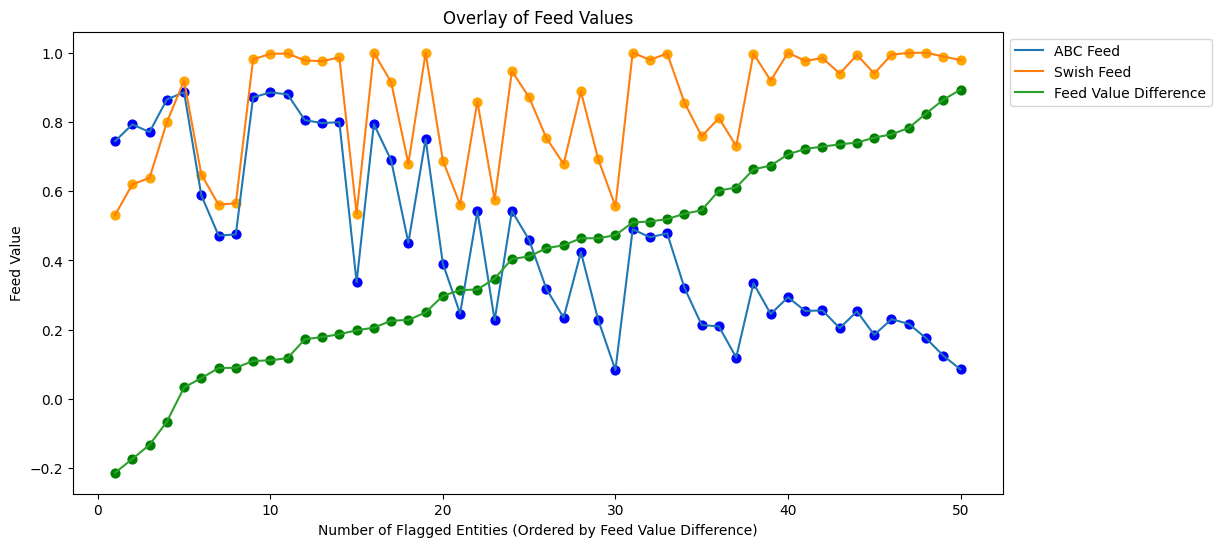

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(x, df['feed_value_abc'], label='ABC Feed')
plt.scatter(x, df['feed_value_abc'], color='blue', s=40, marker='o')

plt.plot(x, df['feed_value_swish'], label='Swish Feed')
plt.scatter(x, df['feed_value_swish'], color='orange', s=40, marker='o')

plt.plot(x, df['feed_value_diff'], label='Feed Value Difference')
plt.scatter(x, df['feed_value_diff'], color='green', s=40, marker='o')

plt.xlabel('Number of Flagged Entities (Ordered by Feed Value Difference)')
plt.ylabel('Feed Value')
plt.title('Overlay of Feed Values')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

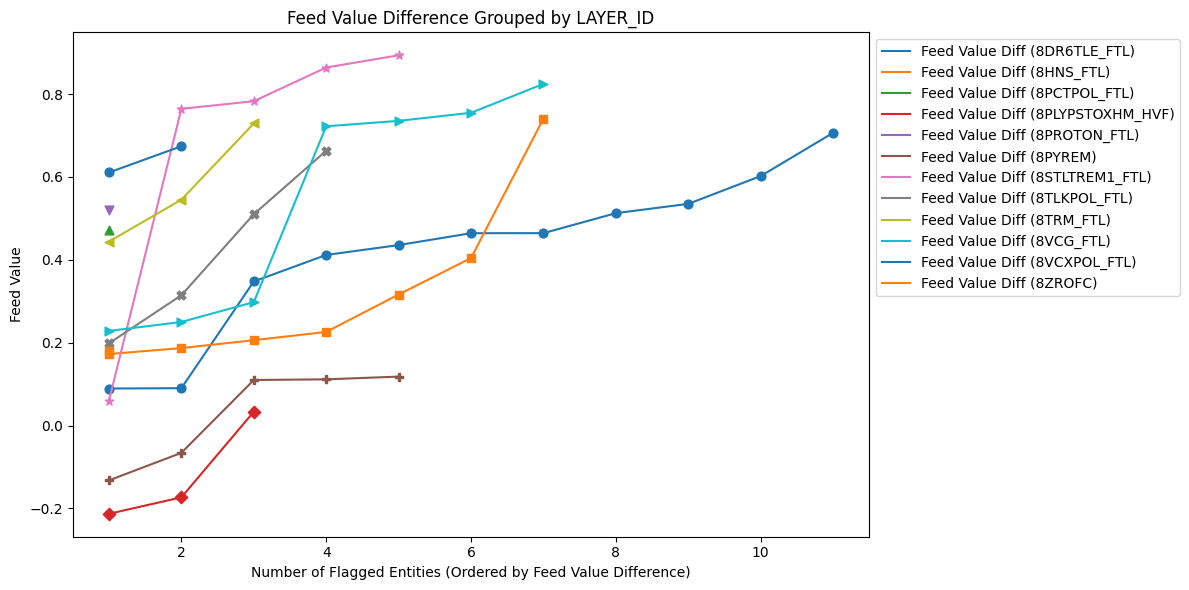

In [36]:
plt.figure(figsize=(12, 6))

# Define a list of marker shapes to cycle through
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', '<', '>']
colors = plt.cm.tab10.colors

for i, (layer, group) in enumerate(df.groupby('LAYER_ID')):
    x = range(1, len(group) + 1)
    marker = markers[i % len(markers)]
    color = colors[i % len(colors)]
    plt.plot(x, group['feed_value_diff'], label=f'Feed Value Diff ({layer})', color=color)
    plt.scatter(x, group['feed_value_diff'], s=40, marker=marker, color=color)

plt.xlabel('Number of Flagged Entities (Ordered by Feed Value Difference)')
plt.ylabel('Feed Value')
plt.title('Feed Value Difference Grouped by LAYER_ID')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

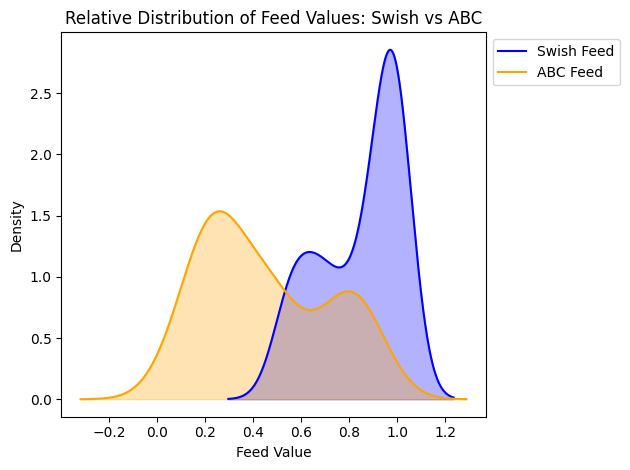

In [26]:
ax = df['feed_value_swish'].plot(kind='kde', label='Swish Feed', color='blue')
df['feed_value_abc'].plot(kind='kde', label='ABC Feed', color='orange', ax=ax)

#Filling the area under the curves
x_swish = ax.get_lines()[0].get_xdata() 
y_swish = ax.get_lines()[0].get_ydata()
ax.fill_between(x_swish, y_swish, color='blue', alpha=0.3)

x_abc = ax.get_lines()[1].get_xdata()
y_abc = ax.get_lines()[1].get_ydata()
ax.fill_between(x_abc, y_abc, color='orange', alpha=0.3)

plt.xlabel('Feed Value')
plt.ylabel('Density')
# plt.title('Kernel Density Estimate: Swish Feed vs ABC Feed (Filled)')
plt.title('Relative Distribution of Feed Values: Swish vs ABC')

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


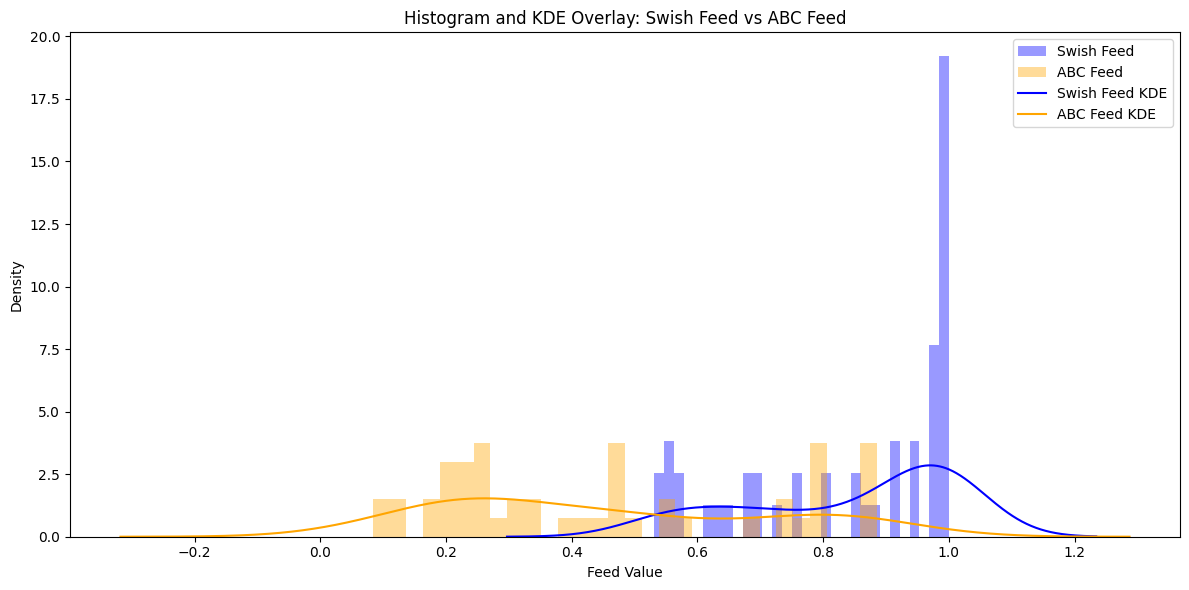

In [27]:
plt.figure(figsize=(12, 6))
# Histogram
plt.hist(df['feed_value_swish'], bins=30, alpha=0.4, label='Swish Feed', color='blue', density=True)
plt.hist(df['feed_value_abc'], bins=30, alpha=0.4, label='ABC Feed', color='orange', density=True)
# KDE
df['feed_value_swish'].plot(kind='kde', label='Swish Feed KDE', color='blue')
df['feed_value_abc'].plot(kind='kde', label='ABC Feed KDE', color='orange')

plt.xlabel('Feed Value')
plt.ylabel('Density')
plt.title('Histogram and KDE Overlay: Swish Feed vs ABC Feed')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()